In [ ]:
import pandas as pd
import numpy as np
import time
import optuna
import argparse
from pprint import pprint
from toolz.dicttoolz import valmap
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error


In [ ]:
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump,load
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
SEED = 7
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/NuevoTPIA.csv')
df.head(100)

,Unnamed: 0,SIN Imputed,T02M,RH2M,PRSS,TPP6,U10M,V10M
0,2008-01-01 00:00:00-03:00,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420
1,2008-01-01 01:00:00-03:00,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589
2,2008-01-01 02:00:00-03:00,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759
3,2008-01-01 03:00:00-03:00,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929
4,2008-01-01 04:00:00-03:00,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541
...,...,...,...,...,...,...,...,...
95,2008-01-04 23:00:00-03:00,1091.556435,25.281419,91.848440,1002.219251,0.000331,-0.771440,1.519284
96,2008-01-05 00:00:00-03:00,999.222549,24.929396,92.671447,1002.235934,-0.000114,-0.677439,1.519206
97,2008-01-05 01:00:00-03:00,981.729061,24.597039,93.300097,1002.322583,0.000081,-0.619975,1.462586
98,2008-01-05 02:00:00-03:00,855.211352,24.264682,93.928748,1002.409233,0.000275,-0.562511,1.405966


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nombres_nuevos = ['Fecha', 'Potencia', 'Temperatura','Humedad','Presión', 'Precipitacion', 'U','V']
# Cambiar los nombres de las columnas
df.columns = nombres_nuevos

In [ ]:
df.head(20)

,Fecha,Potencia,Temperatura,Humedad,Presión,Precipitacion,U,V
0,2008-01-01 00:00:00-03:00,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420
1,2008-01-01 01:00:00-03:00,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589
2,2008-01-01 02:00:00-03:00,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759
3,2008-01-01 03:00:00-03:00,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929
4,2008-01-01 04:00:00-03:00,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541
5,2008-01-01 05:00:00-03:00,717.195424,23.318710,93.913586,999.959376,0.000000,-0.902261,-1.774154
6,2008-01-01 06:00:00-03:00,636.497140,22.969847,93.569716,1000.935885,0.000000,-0.531068,-1.918767
7,2008-01-01 07:00:00-03:00,566.063757,24.355974,88.873767,1001.222567,0.000000,-0.609305,-2.025998
8,2008-01-01 08:00:00-03:00,543.269824,25.742102,84.177818,1001.509249,0.000000,-0.687541,-2.133229
9,2008-01-01 09:00:00-03:00,564.513991,27.128229,79.481869,1001.795931,0.000000,-0.765778,-2.240461


In [ ]:
# Función para categorizar la dirección del viento en Norte o Sur
def categorizar_direccion1(direccion):
    if direccion >= 0:
        return 'U1'
    else:
        return 'U2'
def categorizar_direccion2(direccion):
    if direccion >= 0:
        return 'V1'
    else:
        return 'V2'

# Aplicamos la función de categorización a la columna de dirección del viento
df['DirecciónU'] = df['U'].apply(categorizar_direccion1)
df['DirecciónV'] = df['V'].apply(categorizar_direccion2)

# Calculamos la magnitud del viento utilizando el teorema de Pitágoras
df['Magnitud'] = np.sqrt(np.square(df['U']) + np.square(df['V']))

# Categorizamos la magnitud en tres niveles de cuartil
df['Cuartil de Magnitud'] = pd.qcut(df['Magnitud'], q=3, labels=["Bajo", "Medio", "Alto"])

# Mostramos el DataFrame resultante
df

,Fecha,Potencia,Temperatura,Humedad,Presión,Precipitacion,U,V,DirecciónU,DirecciónV,Magnitud,Cuartil de Magnitud,Hora,Año
0,2008-01-01,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420,U2,V2,1.977304,Bajo,0,2008
1,2008-01-01,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589,U2,V2,2.053493,Bajo,1,2008
2,2008-01-01,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759,U2,V2,2.133122,Medio,2,2008
3,2008-01-01,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929,U2,V2,2.215823,Medio,3,2008
4,2008-01-01,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541,U2,V2,2.068112,Bajo,4,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131457,2022-12-31,2917.003684,35.666498,25.449116,995.890558,0.000000,-3.664459,-0.515961,U2,V2,3.700605,Alto,19,2022
131458,2022-12-31,3214.912340,33.147940,29.386493,996.157851,0.000000,-3.195860,-0.236700,U2,V2,3.204614,Alto,20,2022
131459,2022-12-31,3280.046574,30.629383,33.323870,996.425145,0.000000,-2.727261,0.042562,U2,V1,2.727593,Medio,21,2022
131460,2022-12-31,2955.971259,29.699868,35.320626,997.416281,0.000000,-2.576113,-0.518552,U2,V2,2.627785,Medio,22,2022


In [ ]:
import matplotlib.pyplot as plt

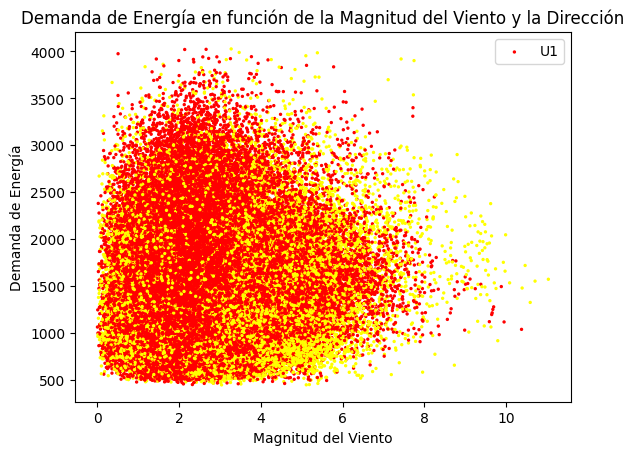

In [ ]:
plt.scatter(df['Magnitud'], df['Potencia'], c=df['DirecciónU'].map({'U1': 'yellow', 'U2': 'red'}),s=2)
plt.xlabel('Magnitud del Viento')
plt.ylabel('Demanda de Energía')
plt.title('Demanda de Energía en función de la Magnitud del Viento y la Dirección')
plt.legend(['U1','U2'])
plt.show()

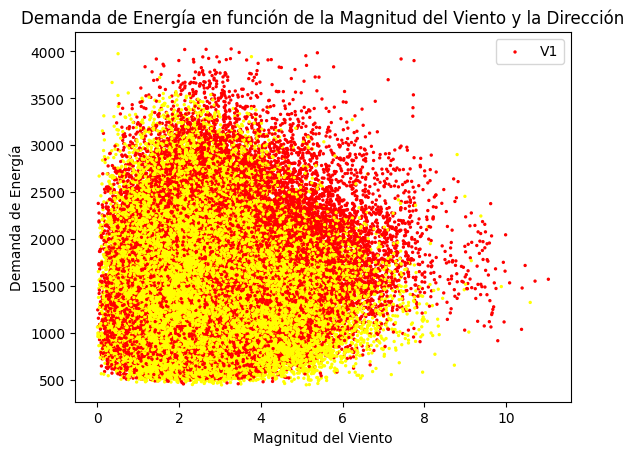

In [ ]:
plt.scatter(df['Magnitud'], df['Potencia'], c=df['DirecciónV'].map({'V1': 'yellow', 'V2': 'red'}),s=2)
plt.xlabel('Magnitud del Viento')
plt.ylabel('Demanda de Energía')
plt.title('Demanda de Energía en función de la Magnitud del Viento y la Dirección')
plt.legend(['V1','V2'])
plt.show()

In [ ]:
df['Fecha'] = df['Fecha'].astype(str)
df['Hora'] = df['Fecha'].str.split(' ').str[1]
df['Fecha']=df['Fecha'].str.split(' ').str[0]
df['Hora']=df['Hora'].str.split('-').str[0]
# Convertir la columna 'Hora' al formato correcto (solo horas como enteros)
df['Hora'] = df['Hora'].apply(lambda x: int(x.split(':')[0]))

<ipython-input-104-49263a5cbd06>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


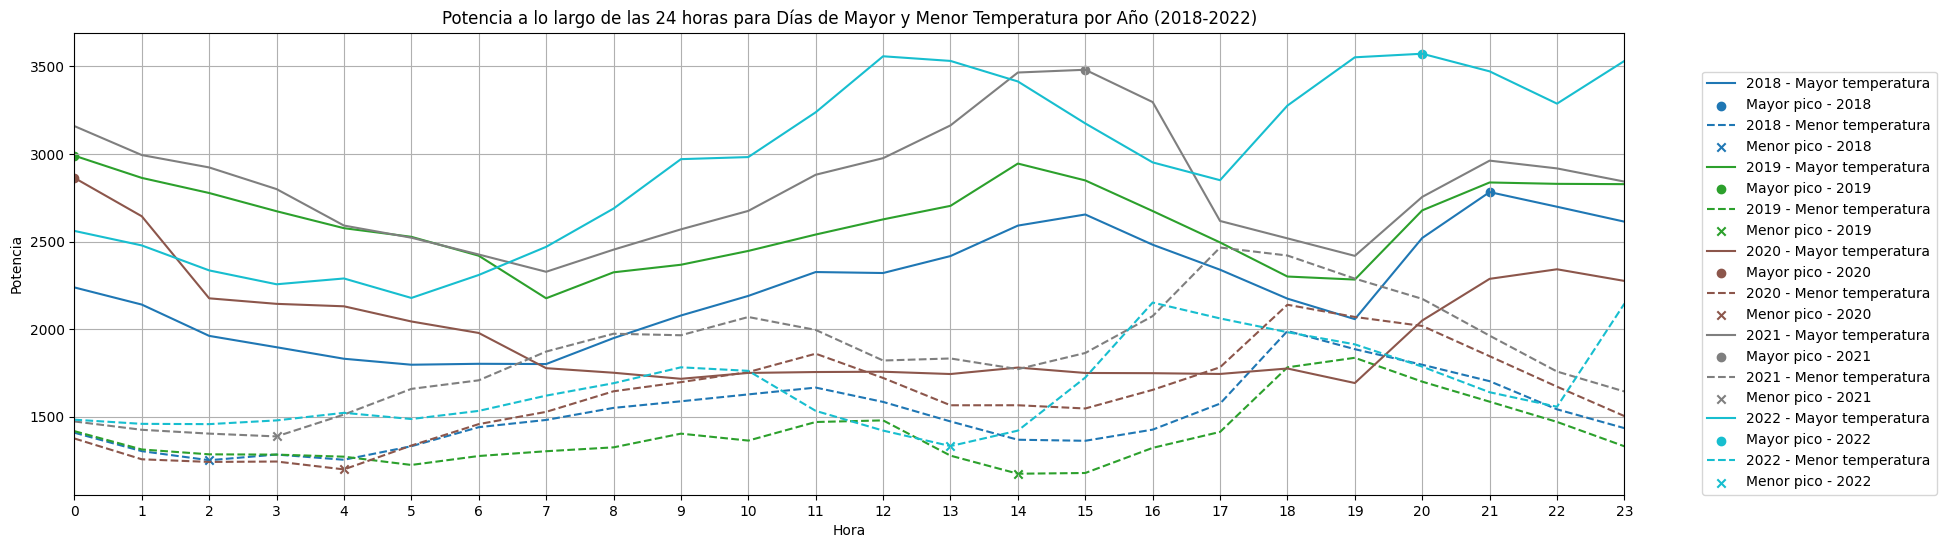

In [ ]:
# Supongamos que df es tu DataFrame original con las columnas 'Fecha', 'Hora', 'Temperatura' y 'Potencia'

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor temperatura de cada año
mayor_temperatura_por_año = df.loc[df.groupby('Año')['Temperatura'].idxmax()]

# Filtrar los días con la menor temperatura de cada año
menor_temperatura_por_año = df.loc[df.groupby('Año')['Temperatura'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor temperatura para el año actual
    mayor_temperatura_actual = mayor_temperatura_por_año[mayor_temperatura_por_año['Año'] == year]
    mayor_temperatura_fecha = mayor_temperatura_actual['Fecha'].iloc[0]
    mayor_temperatura_dia = df[(df['Fecha'] == mayor_temperatura_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_temperatura_dia = mayor_temperatura_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor temperatura del año actual
    plt.plot(mayor_temperatura_dia['Hora'], mayor_temperatura_dia['Potencia'],
             label=f'{year} - Mayor temperatura', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor temperatura
    mayor_pico_potencia = mayor_temperatura_dia.loc[mayor_temperatura_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor temperatura para el año actual
    menor_temperatura_actual = menor_temperatura_por_año[menor_temperatura_por_año['Año'] == year]
    menor_temperatura_fecha = menor_temperatura_actual['Fecha'].iloc[0]
    menor_temperatura_dia = df[(df['Fecha'] == menor_temperatura_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_temperatura_dia = menor_temperatura_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor temperatura del año actual
    plt.plot(menor_temperatura_dia['Hora'], menor_temperatura_dia['Potencia'],
             label=f'{year} - Menor temperatura', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor temperatura
    menor_pico_potencia = menor_temperatura_dia.loc[menor_temperatura_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Temperatura por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

<ipython-input-105-c86f5757aca2>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


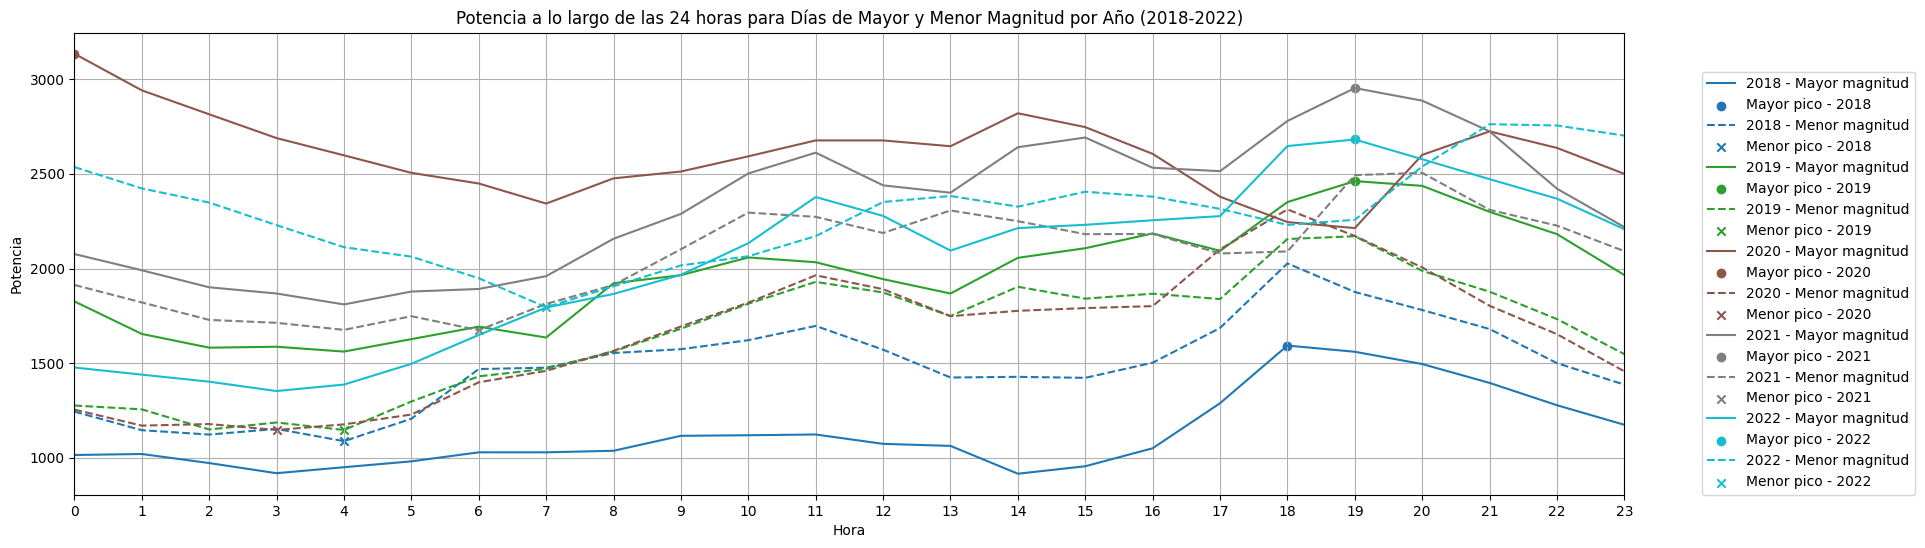

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df es tu DataFrame original con las columnas 'Fecha', 'Hora', 'Magnitud' y 'Potencia'

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor magnitud de cada año
mayor_magnitud_por_año = df.loc[df.groupby('Año')['Magnitud'].idxmax()]

# Filtrar los días con la menor magnitud de cada año
menor_magnitud_por_año = df.loc[df.groupby('Año')['Magnitud'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor magnitud para el año actual
    mayor_magnitud_actual = mayor_magnitud_por_año[mayor_magnitud_por_año['Año'] == year]
    mayor_magnitud_fecha = mayor_magnitud_actual['Fecha'].iloc[0]
    mayor_magnitud_dia = df[(df['Fecha'] == mayor_magnitud_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_magnitud_dia = mayor_magnitud_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor magnitud del año actual
    plt.plot(mayor_magnitud_dia['Hora'], mayor_magnitud_dia['Potencia'],
             label=f'{year} - Mayor magnitud', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor magnitud
    mayor_pico_potencia = mayor_magnitud_dia.loc[mayor_magnitud_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor magnitud para el año actual
    menor_magnitud_actual = menor_magnitud_por_año[menor_magnitud_por_año['Año'] == year]
    menor_magnitud_fecha = menor_magnitud_actual['Fecha'].iloc[0]
    menor_magnitud_dia = df[(df['Fecha'] == menor_magnitud_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_magnitud_dia = menor_magnitud_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor magnitud del año actual
    plt.plot(menor_magnitud_dia['Hora'], menor_magnitud_dia['Potencia'],
             label=f'{year} - Menor magnitud', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor magnitud
    menor_pico_potencia = menor_magnitud_dia.loc[menor_magnitud_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Magnitud por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()


<ipython-input-107-dde3a5f58f69>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


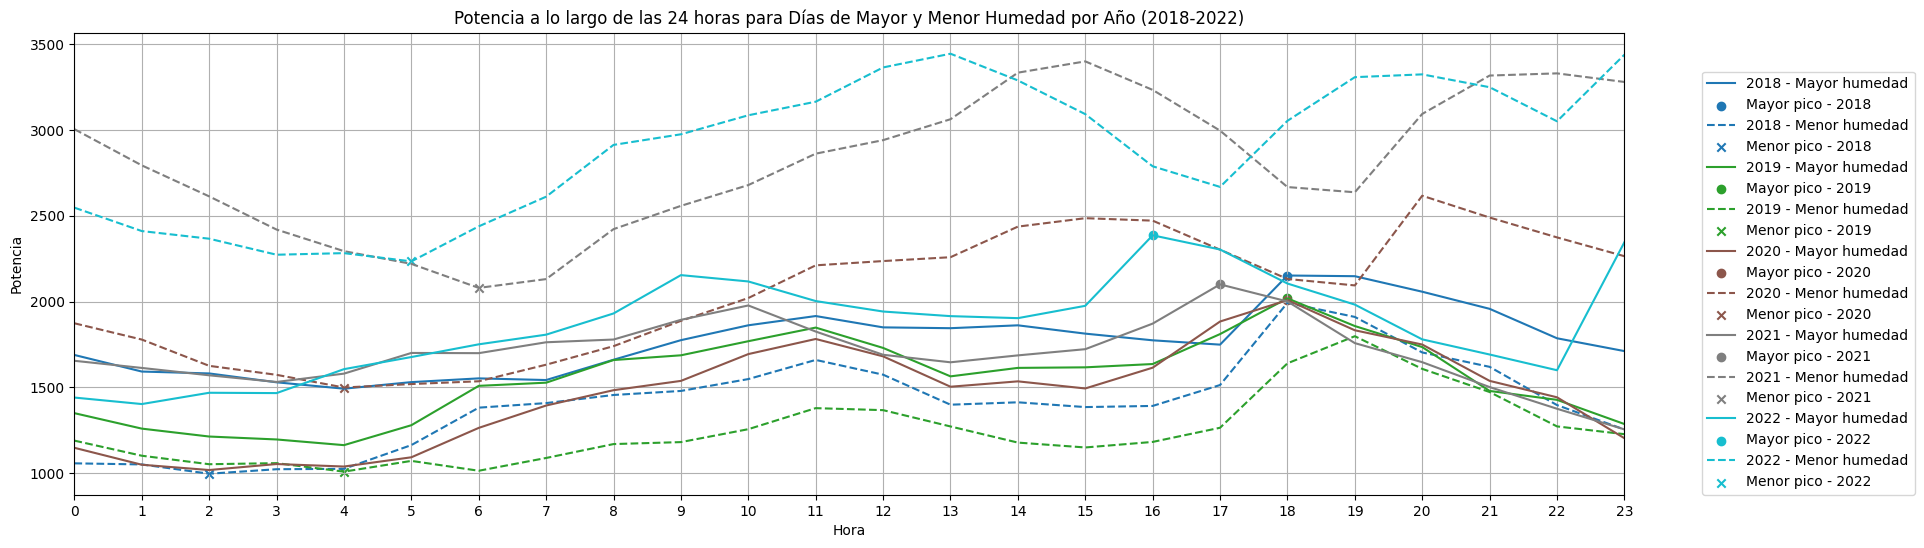

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df es tu DataFrame original con las columnas 'Fecha', 'Hora', 'Humedad' y 'Potencia'

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor humedad de cada año
mayor_humedad_por_año = df.loc[df.groupby('Año')['Humedad'].idxmax()]

# Filtrar los días con la menor humedad de cada año
menor_humedad_por_año = df.loc[df.groupby('Año')['Humedad'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor humedad para el año actual
    mayor_humedad_actual = mayor_humedad_por_año[mayor_humedad_por_año['Año'] == year]
    mayor_humedad_fecha = mayor_humedad_actual['Fecha'].iloc[0]
    mayor_humedad_dia = df[(df['Fecha'] == mayor_humedad_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_humedad_dia = mayor_humedad_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor humedad del año actual
    plt.plot(mayor_humedad_dia['Hora'], mayor_humedad_dia['Potencia'],
             label=f'{year} - Mayor humedad', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor humedad
    mayor_pico_potencia = mayor_humedad_dia.loc[mayor_humedad_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor humedad para el año actual
    menor_humedad_actual = menor_humedad_por_año[menor_humedad_por_año['Año'] == year]
    menor_humedad_fecha = menor_humedad_actual['Fecha'].iloc[0]
    menor_humedad_dia = df[(df['Fecha'] == menor_humedad_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_humedad_dia = menor_humedad_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor humedad del año actual
    plt.plot(menor_humedad_dia['Hora'], menor_humedad_dia['Potencia'],
             label=f'{year} - Menor humedad', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor humedad
    menor_pico_potencia = menor_humedad_dia.loc[menor_humedad_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Humedad por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()
